# Whatsapp Group Chat Data Analysis

**Purpose of project**
* Find most active users in the group
* Find time when most users are active

**Scope**
* Sentiment Analysis on individual member
* Sentiment Analysis on Over-all group chat 

**Assumptions**
* Group has more than 10 active members
* You know how to export whatsapp group chat and enter file path when prompted in code

**How To Use this Notebook**
* Steps to follow:
    * Export Whatsapp group chat as txt
    * Make a copy of this notebook
    * You will be prompted to enter file path in *1.2. Load Whatsapp Group Chat Data*
    * Enter the path of your chat export

**This workbook is interactive. 
You will be prompted to give input file path of your Whatsapp chat export**

## 1. Data Sourcing

### 1.1. Import Libraries

In [13]:
# Import libraries to be used
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

### 1.2. Load Whatsapp Group Chat Data

In [14]:
filepath = input("Please Enter the Whatsapp chat export path below \n*  eg. E:\IIIT-B\Projects\WhatsappGroupChatAnalyses\WhatsappGroupChatExport.txt \n")
df = pd.read_csv(filepath, sep = "delimiter",skip_blank_lines = True, header = None)

c:\Users\tarique.akhtar\.conda\envs\ml\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [15]:
df

,0
0,"11/12/20, 9:45 pm - Messages and calls are end..."
1,"02/10/20, 10:12 pm - Hulk created group ""Frien..."
2,"11/12/20, 9:45 pm - Hulk added you"
3,"11/12/20, 11:54 pm - Super Man: Welcome Iron M..."
4,"11/12/20, 11:56 pm - Iron Man: Thank you Super..."
...,...
4110,"27/12/20, 11:58 pm - Iron Man: Hum bhi"
4111,"27/12/20, 11:58 pm - Daredevil: Aur sweet wala..."
4112,"27/12/20, 11:58 pm - Daredevil: Bye...."
4113,"27/12/20, 11:58 pm - Iron Man: Bye"


## 2. Data Preperation

In [16]:
# extract date values and return as list of string
def getdate(x):
    res = re.search("\d\d/\d\d/\d\d",x)
    if res != None:
        return res.group()
    else:
        return ""
#datepattern = re.compile("../../..")
df["Date"] = list(map(lambda x : getdate(x), df.iloc[:,0]))


## Merge multiline chat data
for i in range(0,len(df)):
    if df["Date"][i] == "":
        c=i-1
        for j in range(i,len(df)):
            if df["Date"][j] == "":
                df.iloc[c,0] = " ".join([df.iloc[c,0],df.iloc[j,0]])
                    
            else:
                i=j-1
                break
    else:
        df.iloc[i,0] = df.iloc[i,0]
        
        
## Remove rows where date is empty
df.drop(np.where(df.iloc[:,1]=="")[0],inplace =True)
## Reindex the dataframe
df.index = range(0,len(df))


##Remove date from original text data using substitute function of regular expression
df.iloc[:,0] = list(map(lambda x : re.sub("../../..","", x)[2:],df.iloc[:,0]))



## Extract Day Month and Year from Date 
df["Day"] = list(map(lambda d : d.split("/")[0], df.Date))
df["Months"] = list(map(lambda d : d.split("/")[1], df.Date))
df["Year"] = list(map(lambda d : d.split("/")[2], df.Date))


## extract time stamp from chat data and store in new column Time and Am
def gettime(x):
    res = re.search(".*\d:\d\d\s[a|p]m", x)
    if res != None:
        return res.group()
    else:
        return ""
Timestamp = list(map(lambda x : gettime(x),df.iloc[:,0])) 

df["Time"] = list(map(lambda t : t.split(" ")[0],Timestamp))
df["Hour"] = list(map(int,list(map(lambda t : t.split(":")[0],df["Time"]))))
df["Minute"] = list(map(int,list(map(lambda t : t.split(":")[1],df["Time"]))))
df["AmPm"] = list(map(lambda t : t.split(" ")[1],Timestamp))


## Remove Timestamps from chat
df.iloc[:,0] = list(map(lambda x : re.sub(".*\d:\d\d\s[a|p]m","", x)[2:],df.iloc[:,0]))


## get sender
def getsender(x):
    res = re.search(re.compile(".*?: "),x)
    if res !=None:
        return res.group()[1:-2]
    else:
        return ""
    
    
df["sender"] =list(map(getsender,df.iloc[:,0]))


## Drop rows of activity messages - member added/removed/left/group name change/icon change/others
df.drop((np.where(df["sender"]=="")[0]),inplace = True)
## Reindex the dataframe
df.index = range(0,len(df))


## extract final message from chat data
def getmessage(x):
    res = re.search(": .*",x)
    if res != None:
        return res.group()[2:]
    else:
        return None

df["Message"] = list(map(getmessage,df.iloc[:,0]))


## Drop column 0
df = df.drop(0,axis =1)

## 3. Data Exploration

In [17]:
df.head()

,Date,Day,Months,Year,Time,Hour,Minute,AmPm,sender,Message
0,11/12/20,11,12,20,11:54,11,54,pm,Super Man,Welcome Iron Man in Friend group
1,11/12/20,11,12,20,11:56,11,56,pm,Iron Man,Thank you Super Man
2,11/12/20,11,12,20,11:56,11,56,pm,Super Man,👍
3,12/12/20,12,12,20,8:26,8,26,am,Bat Man,This message was deleted
4,12/12/20,12,12,20,8:26,8,26,am,Bat Man,Wow


In [18]:
## Preparing data for visualisation

## Find unique members in group
group_members = list(set(df["sender"]))

## Find count of messages shared by each member
n_message = list(map(lambda x : len(np.where(df["sender"]==x)[0]),group_members)) 

## Create a dataframe to store above values
activity_data = pd.DataFrame({"sender": group_members,"n_count":n_message})
## Sort data for convenience and rearrange index
activity_data = activity_data.sort_values(by=["n_count"], ascending=False)
activity_data.index = range(0,len(activity_data))

## creating groups of data by time meridian
timemeridian = df.groupby(by = "AmPm")

amhours = timemeridian.get_group("am")
pmhours = timemeridian.get_group("pm")

## getting hourly activity counts
amhourcounts = amhours.Hour.value_counts().sort_index()
pmhourcounts = pmhours.Hour.value_counts().sort_index()

In [19]:
activity_data

,sender,n_count
0,Daredevil,1661
1,Iron Man,504
2,Super Man,356
3,Captain America,286
4,Captain,227
5,Luke Cage,193
6,Hulk,135
7,Bat Man,120
8,Silver Surfer,90
9,Storm,53


### 3.1 Top Active Members

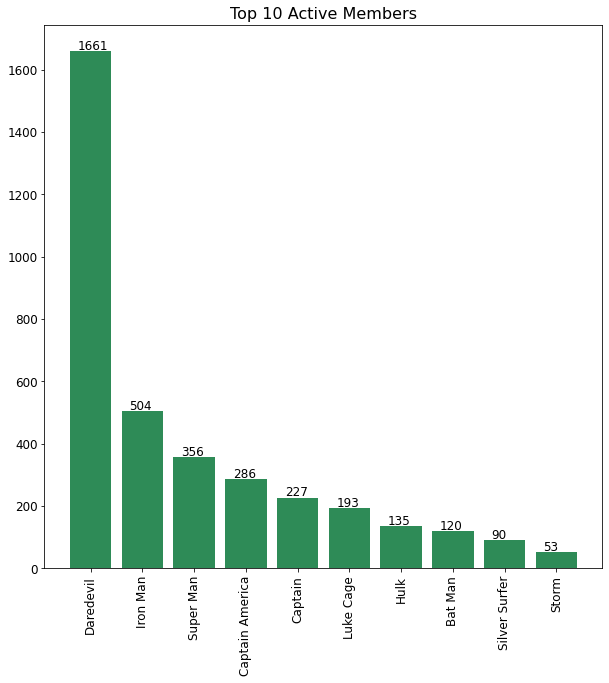

In [20]:
## Most active members in group

X = activity_data["sender"][:10]
Y = activity_data.n_count[:10]

plt.figure(figsize=[10,10])

plt.title("Top 10 Active Members", size = 16)

plt.bar(x = X, height= Y, color = "seagreen")
plt.xticks(rotation = 90, size = 12)
plt.yticks(size = 12)

for i in range(0,10):
    plt.annotate(text = Y[i], xy = (i-0.25,Y[i]+5), size = 12)

plt.show()


In [23]:
from plotly import express as px
z = df['Date'].value_counts() 
z1 = z.to_dict() #converts to dictionary
df['Msg_count'] = df['Date'].map(z1)
### Timeseries plot 
fig = px.line(x=df['Date'],y=df['Msg_count'])
fig.update_layout(title='Analysis of number of messages using TimeSeries plot.',
                  xaxis_title='Month',
                  yaxis_title='No. of Messages')
fig.update_xaxes(nticks=20)
fig.show()

### 3.2 Activity Throughout Day

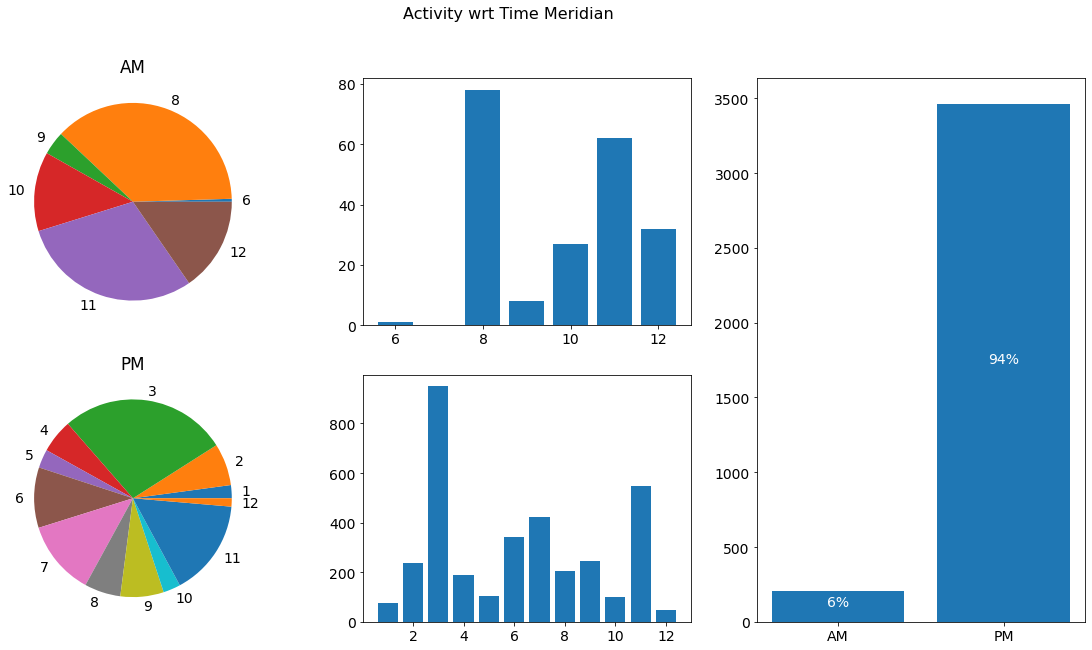

In [21]:
fig = plt.figure(figsize=[20,10])
mpl.rcParams['font.size'] = 14.0

fig.suptitle("Activity wrt Time Meridian", size = 16)

gs = GridSpec(2,3) # 2 rows and 3 columns
ax1 = fig.add_subplot(gs[0,0]) # first row, first col
ax2 = fig.add_subplot(gs[0,1]) # first row, second col
ax3 = fig.add_subplot(gs[1,0]) # second row, first col
ax4 = fig.add_subplot(gs[1,1]) # second row, second col
ax5 = fig.add_subplot(gs[:,2]) # all row, third col

# Pie plot for messages shared in AM time meridian
ax1.pie(amhourcounts.values, labels = amhourcounts.index)
ax1.set_title("AM")
# Bar plot for messages shared in AM time meridian
ax2.bar(amhourcounts.index,amhourcounts.values)

# Pie plot for messages shared in PM time meridian
ax3.pie(pmhourcounts.values, labels = pmhourcounts.index)
ax3.set_title("PM")
# Bar plot for messages shared in PM time meridian
ax4.bar(pmhourcounts.index,pmhourcounts.values)

# Bar plot showing AM vs PM
ax5.bar(["AM","PM"], [len(amhours),len(pmhours)])
ax5.annotate(text = str(round(100*len(amhours)/(len(amhours)+len(pmhours)))) + "%", xy = [0,len(amhours)/2], color = "white", size = 14, horizontalalignment = "center")
ax5.annotate(text = str(round(100*len(pmhours)/(len(amhours)+len(pmhours)))) + "%", xy = [1,len(pmhours)/2], color = "white", size = 14, horizontalalignment = "center")


plt.show()

In [34]:
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["Message"]]
df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["Message"]]
df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["Message"]]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tarique.akhtar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
df

,Date,Day,Months,Year,Time,Hour,Minute,AmPm,sender,Message,Msg_count,message_length,Positive,Negative,Neutral
0,11/12/20,11,12,20,11:54,11,54,pm,Super Man,Welcome Iron Man in Friend group,3,32,0.608,0.0,0.392
1,11/12/20,11,12,20,11:56,11,56,pm,Iron Man,Thank you Super Man,3,19,0.762,0.0,0.238
2,11/12/20,11,12,20,11:56,11,56,pm,Super Man,👍,3,1,0.000,0.0,0.000
3,12/12/20,12,12,20,8:26,8,26,am,Bat Man,This message was deleted,283,24,0.000,0.0,1.000
4,12/12/20,12,12,20,8:26,8,26,am,Bat Man,Wow,283,3,1.000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3664,27/12/20,27,12,20,11:58,11,58,pm,Iron Man,Hum bhi,348,7,0.000,0.0,1.000
3665,27/12/20,27,12,20,11:58,11,58,pm,Daredevil,Aur sweet wala dream v,348,22,0.714,0.0,0.286
3666,27/12/20,27,12,20,11:58,11,58,pm,Daredevil,Bye....,348,7,0.000,0.0,1.000
3667,27/12/20,27,12,20,11:58,11,58,pm,Iron Man,Bye,348,3,0.000,0.0,1.000


In [36]:
x = sum(df["Positive"])
y = sum(df["Negative"])
z = sum(df["Neutral"])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive 😊 ")
    elif (b>a) and (b>c):
        print("Negative 😠 ")
    else:
        print("Neutral 🙂 ")
sentiment_score(x, y, z)

Neutral 🙂 
